# Load libs

In [83]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import itertools

import re

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk.tokenize import word_tokenize 

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import plotly.graph_objects as go
import numpy as np

[nltk_data] Downloading package wordnet to /home/fisz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load dataset

In [67]:
df = pd.read_csv("dataset.csv", usecols=["id", "search_query", "description"])

# Data analysis
## Query distribution

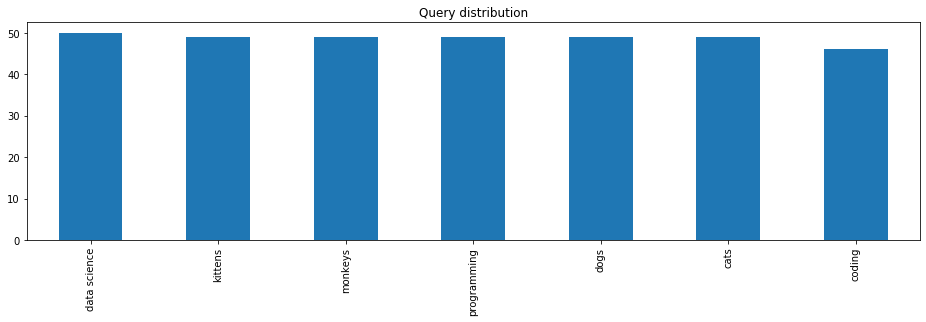

In [68]:
df["search_query"].value_counts().plot(kind="bar", title='Query distribution', figsize=(16, 4))

## Words number in description distribution

Text(0, 0.5, 'Descriptions number with words amount')

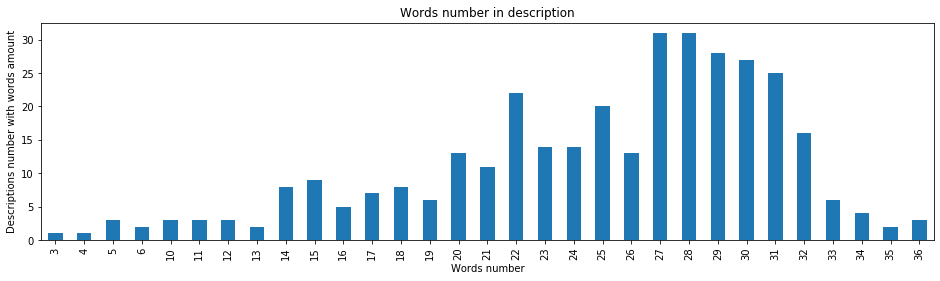

In [69]:
df["description"].str.split().apply(len).value_counts().sort_index().plot(kind="bar", figsize=(16, 4))

plt.title('Words number in description')
plt.xlabel('Words number')
plt.ylabel('Descriptions number with words amount')

## Dictionary analysis
### Raw dictionary

In [70]:
raw_dictionary = pd.Series(itertools.chain.from_iterable(df["description"].str.split()))
print("Raw dictionary size: {} unique words.".format(len(np.unique(raw_dictionary))))

Raw dictionary size: 2861 unique words.


### Cleaning descriptions

In [71]:
stemmer = PorterStemmer() 
lemmatizer = WordNetLemmatizer()

def clean_description(description: str):
    temp = description
    
    # remove urls
    temp = " ".join(filter(lambda word: not word.startswith("http"), temp.split()))
    
    # remove not alphanumeric and whitespace
    temp = re.sub("[^a-zA-Z\d\s]", "", temp)
    
    # lemmatization
    temp = lemmatizer.lemmatize(temp)
    
    # stemming
    temp = stemmer.stem(temp)
    return temp
    
df["cleaned_description"] = df["description"].apply(clean_description)

In [72]:
cleaned_dictionary = pd.Series(itertools.chain.from_iterable(df["cleaned_description"].str.split()))
print("Cleaned dictionary size: {} unique words.".format(len(np.unique(cleaned_dictionary))))

Cleaned dictionary size: 1913 unique words.


# Embedding
## BOW

In [84]:
bow_embeddings = TfidfVectorizer().fit_transform(df["cleaned_description"])
encoded_labels = LabelEncoder().fit_transform(df["search_query"])

trunc = TruncatedSVD(n_components=3).fit_transform(bow_embeddings)

In [99]:
def add_new_lines(description: str) -> str:
    result = []
    for i, word in enumerate(description.split()):
        if i % 5 == 0:
            result.append("<br>")
        result.append(word)
    return " ".join(result)

In [103]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=trunc[:, 0],
    y=trunc[:, 1],
    z=trunc[:, 2],
    hovertext = "Query: <b>" + df["search_query"] + "</b>" + df["description"].apply(add_new_lines),
    mode='markers',
    marker=dict(
        size=20,
        color=encoded_labels,
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()